In [1]:
import os
import gc
import datetime
import time

import pandas as pd
import numpy as np
import lightgbm as lgb
import feather

import matplotlib.pyplot as plt
import seaborn as sns

inpath = '../input/'
suffix = ''
outpath = ''
savepath = ''
debug=0


In [2]:
nrows=      184903891-1
#train_size=  75000000
#val_size=     2500000
#offset=      75000000
#frm=nrows-offset
#to=frm+train_size

#day 8 starting from=68941878
#day 9 starts 131886953
#day 9 ends 184903889

#day 9 hour 4 starts; 144708152
#day 9 hour 4 ends; 148740842

train_size=  62945075
val_size=    53016936
offset=      68941878
frm=offset
to=frm+train_size+val_size


In [3]:
frm, to

(68941878, 184903889)

In [4]:


def do_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return df 

def do_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Counting unqiue ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return df 
    
def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return df 

def do_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return df 

def do_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return df 


def DO(frm, to):
    dtypes = {
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint16',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8',
            'click_id'      : 'uint32',
            }
    
    print('loading train data...')
    train_df = feather.read_dataframe('/kaggle1/td-cache/train_base.feather')
    train_df = train_df.iloc[frm:to]
        
    gc.collect()
    
    print('loading test data...')
    test_df = feather.read_dataframe('/kaggle1/td-cache/test_base.feather')
    train_df=train_df.append(test_df)
    
    del test_df
    gc.collect()
    
    print('Extracting new features...')
    
    gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'channel', 'X0', 'uint8', show_max=True ); gc.collect()
    train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app', 'X1', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'app', 'X3', 'uint8', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'device', 'X5', 'uint16', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['app'], 'channel', 'X6', show_max=True ); gc.collect()
    train_df = do_cumcount( train_df, ['ip'], 'os', 'X7', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app', 'X8', show_max=True ); gc.collect()
    train_df = do_count( train_df, ['ip', 'day', 'hour'], 'ip_tcount', show_max=True ); gc.collect()
    train_df = do_count( train_df, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
    train_df = do_count( train_df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()    
    train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
    train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
    train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
    train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()

    print('doing nextClick')
    #predictors=[]
    
    new_feature = 'nextClick'
    filename='nextClick_%d_%d.csv'%(frm,to)

    if os.path.exists(filename):
        print('loading from save file')
        QQ=pd.read_csv(filename, header=None)[0].values
    else:
        D=2**26
        train_df['category'] = (train_df['ip'].astype(str) + "_" + train_df['app'].astype(str) + "_" + train_df['device'].astype(str) \
            + "_" + train_df['os'].astype(str)).apply(hash) % D
        click_buffer= np.full(D, 3000000000, dtype=np.uint32)

        train_df['epochtime']= train_df['click_time'].astype(np.int64) // 10 ** 9
        next_clicks= []
        for category, t in zip(reversed(train_df['category'].values), reversed(train_df['epochtime'].values)):
            next_clicks.append(click_buffer[category]-t)
            click_buffer[category]= t
        del(click_buffer)
        QQ= list(reversed(next_clicks))

        if not debug:
            print('saving')
            pd.DataFrame(QQ).to_csv(filename,index=False)
            
    to_drop = [x for x in train_df.columns if x in ['epochtime','category','click_time']]
    train_df.drop(to_drop, axis=1, inplace=True)

    train_df[new_feature] = pd.Series(QQ).astype('float32')
    #predictors.append(new_feature)

    train_df[new_feature+'_shift'] = train_df[new_feature].shift(+1).values
    #predictors.append(new_feature+'_shift')
    
    del QQ
    gc.collect()

    train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
    train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
    train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

    print("vars and data type: ")
    train_df.info()
    
    train_df.reset_index(drop=True, inplace=True)
    feather.write_dataframe(train_df, '9671_train_from{}_to{}.feather'.format(frm, to))

    return train_df
    



In [5]:
import feather
import datetime

print(datetime.datetime.now())
fname = '9671_train_from{}_to{}.feather'.format(frm, to)
if not os.path.exists(fname):
    print('generating')
    DO(frm, to)
train_df = feather.read_dataframe(fname)    
print(datetime.datetime.now())

2018-04-19 17:25:57.903187
2018-04-19 17:27:27.788046


In [6]:
#import feather
#df = feather.read_dataframe('/kaggle1/td-cache/train_base.feather')
    

In [7]:
#train_df.nextClick.max()

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134752480 entries, 0 to 134752479
Data columns (total 26 columns):
app                         uint16
channel                     uint16
day                         uint8
device                      uint16
hour                        uint8
ip                          uint32
is_attributed               uint8
os                          uint16
X0                          uint8
X1                          uint32
X2                          uint8
X3                          uint8
X4                          uint8
X5                          uint16
X6                          uint32
X7                          uint32
X8                          uint32
ip_tcount                   uint16
ip_app_count                uint16
ip_app_os_count             uint16
ip_tchan_count              float32
ip_app_os_var               float32
ip_app_channel_var_day      float32
ip_app_channel_mean_hour    float32
nextClick                   float32
nextClick_

In [6]:
def lgb_modelfit_nocv(params, train_df, val_dfs, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'nthread': 8,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    dtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                         feature_name=predictors,
                         categorical_feature=categorical_features)
    valid_names = ['train']
    valid_sets = [dtrain]
    for val_name, val_df in val_dfs.items():
        valid_names.append(val_name)
        dvalid = lgb.Dataset(val_df[predictors].values, 
                             label=val_df[target].values,
                             feature_name=predictors,
                             categorical_feature=categorical_features)
        valid_sets.append(dvalid)

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     dtrain, 
                     valid_sets=valid_sets,
                     valid_names=valid_names, 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    #print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return bst1, bst1.best_iteration, evals_results


In [7]:
categorical = ['app', 'device', 'os', 'channel', 'hour']

predictors = []
predictors.extend(['nextClick', 'nextClick_shift'])
predictors.extend([
    'app','device','os', 'channel', 'hour', #'day', 
    'ip_tcount', 'ip_tchan_count', 'ip_app_count',
    'ip_app_os_count', 
    'ip_app_os_var',
    'ip_app_channel_var_day','ip_app_channel_mean_hour',
    'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])

print('categorical:', categorical)

categorical: ['app', 'device', 'os', 'channel', 'hour']


In [10]:
def _add_mean_nc(df, group_cols, name):
    gp = df[group_cols + ['nextClick']].groupby(by=group_cols).nextClick.mean().rename(columns={'nextClick': name}).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

train_df = _add_mean_nc(train_df, ['ip', 'app', 'device', 'os', 'channel'], 'iadoc_mean_nc')
train_df = _add_mean_nc(train_df, ['ip', 'channel'], 'ic_mean_nc')
predictors.extend(['iadoc_mean_nc', 'ic_mean_nc'])

In [11]:
#train_df = do_count( train_df, ['ip', 'app', 'channel'], 'ip_app_channel_count', 'uint16', show_max=True ); gc.collect()
#train_df = do_count( train_df, ['ip', 'app', 'os', 'hour'], 'ip_app_os_hour_count', 'uint16', show_max=True ); gc.collect()
#predictors.extend(['ip_app_channel_count', 'ip_app_os_hour_count'])


In [15]:
train_df['iadoc_mean_nc'] = train_df['0_x']
train_df['ic_mean_nc'] = train_df['0_y']
del train_df['0_x']
del train_df['0_y']


In [21]:
def DO2_train8_val9(train_df, frm, to, val_size, predictors, categorical):
    
    target = 'is_attributed'
    print('predictors', predictors)
    
    len_train = to - frm
    
    test_df = train_df[len_train:]
    val_df = train_df[(len_train-val_size):len_train]
    train_df = train_df[:(len_train-val_size)]

    print("train size: ", len(train_df))
    print("valid size: ", len(val_df))
    print("test size : ", len(test_df))
    
    val_dfs = {
        'h4':  val_df[val_df.hour ==  4],
        'h5':  val_df[val_df.hour ==  5],
        'h9':  val_df[val_df.hour ==  9],
        'h10': val_df[val_df.hour == 10],
        'h13': val_df[val_df.hour == 13],
        'h14': val_df[val_df.hour == 14]
    }    
    
    gc.collect()

    print("Training...")
    start_time = time.time()

    params = {
        'learning_rate': 0.2,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 15,  # 2^max_depth - 1
        'max_depth': 4,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200, # because training data is extremely unbalanced 
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        
    }
    bst, best_iteration, evals_results = lgb_modelfit_nocv(params, 
                            train_df, 
                            val_dfs, 
                            predictors, 
                            target, 
                            objective='binary', 
                            metrics='auc',
                            early_stopping_rounds=30, 
                            verbose_eval=True, 
                            num_boost_round=1000, 
                            categorical_features=categorical)

    print('[{}]: model training time'.format(time.time() - start_time))
    del train_df
    del val_df
    gc.collect()

    
    #print('Plot feature importances...')
    #ax = lgb.plot_importance(bst, max_num_features=100)
    #plt.show()
    

    return bst, evals_results
    

In [22]:
bst, evals_results = DO2_train8_val9(train_df, frm, to, val_size, predictors, categorical)

predictors ['nextClick', 'nextClick_shift', 'app', 'device', 'os', 'channel', 'hour', 'ip_tcount', 'ip_tchan_count', 'ip_app_count', 'ip_app_os_count', 'ip_app_os_var', 'ip_app_channel_var_day', 'ip_app_channel_mean_hour', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'iadoc_mean_nc', 'ic_mean_nc']
train size:  62945075
valid size:  53016936
test size :  18790469
Training...
preparing validation datasets


/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.977895	h4's auc: 0.971163	h5's auc: 0.97438	h9's auc: 0.970471	h10's auc: 0.970606	h13's auc: 0.973428	h14's auc: 0.9764
[20]	train's auc: 0.980686	h4's auc: 0.973893	h5's auc: 0.977452	h9's auc: 0.973509	h10's auc: 0.974101	h13's auc: 0.976995	h14's auc: 0.979761
[30]	train's auc: 0.98312	h4's auc: 0.976222	h5's auc: 0.979035	h9's auc: 0.976013	h10's auc: 0.976945	h13's auc: 0.980206	h14's auc: 0.982716
[40]	train's auc: 0.984209	h4's auc: 0.976971	h5's auc: 0.979663	h9's auc: 0.976832	h10's auc: 0.977767	h13's auc: 0.981243	h14's auc: 0.983945
[50]	train's auc: 0.984884	h4's auc: 0.977545	h5's auc: 0.980071	h9's auc: 0.977247	h10's auc: 0.978295	h13's auc: 0.981897	h14's auc: 0.98456
[60]	train's auc: 0.985377	h4's auc: 0.977806	h5's auc: 0.980306	h9's auc: 0.977475	h10's auc: 0.978551	h13's auc: 0.982054	h14's auc: 0.984701
[70]	train's auc: 0.985759	h4's auc: 0.978028	h5's auc: 0.980465	h9's auc: 0.97

Plot feature importances...


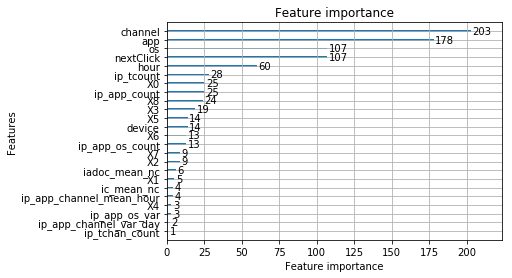

In [20]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst)
plt.show()

In [8]:
frm, to

(68941878, 184903889)

In [9]:
from sklearn.model_selection import train_test_split

def DO2(train_df, predictors, categorical):

    target = 'is_attributed'
    print('predictors', predictors)

    frm, to = (68941878, 184903889)
    
    len_train = to - frm
    
    # exclude day 8 from train_df
    offset = 131886953 - 68941878
    
    test_df = train_df[len_train:]
    
    train_df, val_df = train_test_split(train_df[offset:len_train], test_size=.1)

    print("train size: ", len(train_df))
    print("valid size: ", len(val_df))
    print("test size : ", len(test_df))
    
    val_dfs = {
        'val':  val_df,
    }    
    
    gc.collect()

    print("Training...")
    start_time = time.time()

    params = {
        'learning_rate': 0.2,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 15,  # 2^max_depth - 1
        'max_depth': 4,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200, # because training data is extremely unbalanced 
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        
    }
    bst, best_iteration, evals_results = lgb_modelfit_nocv(params, 
                            train_df, 
                            val_dfs, 
                            predictors, 
                            target, 
                            objective='binary', 
                            metrics='auc',
                            early_stopping_rounds=30, 
                            verbose_eval=True, 
                            num_boost_round=1000, 
                            categorical_features=categorical)

    print('[{}]: model training time'.format(time.time() - start_time))
    del train_df
    del val_df
    gc.collect()

    
    #print('Plot feature importances...')
    #ax = lgb.plot_importance(bst, max_num_features=100)
    #plt.show()
    

    return bst, evals_results
    

In [10]:
#day 9 starts 131886953
#day 9 ends 184903889
bst, evals_results = DO2(train_df, predictors, categorical)

predictors ['nextClick', 'nextClick_shift', 'app', 'device', 'os', 'channel', 'hour', 'ip_tcount', 'ip_tchan_count', 'ip_app_count', 'ip_app_os_count', 'ip_app_os_var', 'ip_app_channel_var_day', 'ip_app_channel_mean_hour', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
train size:  47715242
valid size:  5301694
test size :  18790469
Training...
preparing validation datasets


/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.973503	val's auc: 0.972108
[20]	train's auc: 0.978281	val's auc: 0.976846
[30]	train's auc: 0.980921	val's auc: 0.979198
[40]	train's auc: 0.981933	val's auc: 0.979968
[50]	train's auc: 0.982595	val's auc: 0.98039
[60]	train's auc: 0.983104	val's auc: 0.980665
[70]	train's auc: 0.983516	val's auc: 0.980873
[80]	train's auc: 0.983894	val's auc: 0.981049
[90]	train's auc: 0.98421	val's auc: 0.981138
[100]	train's auc: 0.984465	val's auc: 0.981258
[110]	train's auc: 0.984674	val's auc: 0.981307
[120]	train's auc: 0.984896	val's auc: 0.981386
[130]	train's auc: 0.98506	val's auc: 0.981408
[140]	train's auc: 0.985225	val's auc: 0.981453
[150]	train's auc: 0.985358	val's auc: 0.981491
[160]	train's auc: 0.98551	val's auc: 0.981528
[170]	train's auc: 0.985656	val's auc: 0.981587
[180]	train's auc: 0.985802	val's auc: 0.981583
[190]	train's auc: 0.98592	val's auc: 0.981582
[200]	train's auc: 0.986056	val's auc: 0

In [35]:
len_train = to - frm
val_df = train_df[(len_train-val_size):len_train]

In [ ]:
val_df['pred'] = bst.predict(val_df[predictors], num_iteration=-1)

4 9666
4 0.862758663037
4 0.0690607356552


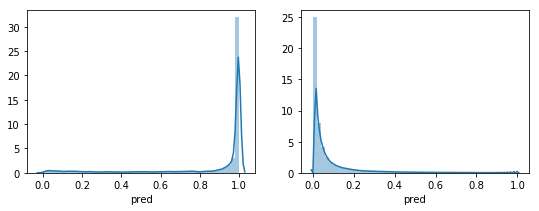

In [57]:

for hour in [4]: #, 5, 9, 10, 13, 14]:
    pos_cond = (val_df.hour==hour)&(val_df.is_attributed==1)
    neg_cond = (val_df.hour==hour)&(val_df.is_attributed==0)
    print(hour, len(val_df[(val_df.hour==hour)&(val_df.is_attributed==1)]))
    print(hour, val_df[pos_cond].pred.mean())
    print(hour, val_df[neg_cond].pred.mean())
    #df = val_df[val_df.hour==hour]
    #print(df.channel.value_counts())
    #print(val_df[pos_cond].channel.value_counts())
    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    sns.distplot(val_df[pos_cond].pred)
    plt.subplot(122)
    sns.distplot(val_df[neg_cond].pred)
    

In [63]:
pd.set_option("display.max_columns", 200)
pd.set_option('display.max_colwidth', int(1e3))

pd.options.display.max_columns =999
pd.options.display.max_colwidth =999
pd.options.display.max_rows = 999

In [66]:
#sample false negatives
#val_df[(val_df.hour==hour)&(val_df.is_attributed==1)].sort_values(by='pred', ascending=True)
val_df[(val_df.hour==hour)&(val_df.is_attributed==1)].nextClick.mean()

8.7237203e+08

In [68]:
#val_df[(val_df.hour==hour)&(val_df.is_attributed==0)].nextClick.mean()

4

In [76]:
#val_df.groupby(by=['ip', 'app', 'device', 'os', 'channel']).nextClick.mean().reset_index().rename(columns={'nextClick': 'iadoc_mean_nc'}).head(10)

,ip,app,device,os,channel,iadoc_mean_nc
0,1,1,1,2,125,1.489762e+09
1,1,1,1,9,125,6.668000e+03
2,1,1,1,48,13,9.660400e+04
3,1,2,1,2,477,1.489804e+09
4,1,2,1,9,477,1.489804e+09
5,1,2,1,48,477,1.489776e+09
6,1,2,1,52,477,6.598200e+04
7,1,3,1,48,182,1.489776e+09
8,1,3,1,52,182,1.489776e+09
9,1,4,1,48,101,1.489776e+09


In [32]:
#g = lgb.create_tree_digraph(bst)
#g.render('digraph')

In [33]:
len(train_df)

134752480

In [49]:
val_df.head()

,app,channel,day,device,hour,ip,is_attributed,os,X0,X1,...,ip_tcount,ip_app_count,ip_app_os_count,ip_tchan_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour,nextClick,nextClick_shift,pred
62945075,11,487,9,1,0,201143,0,13,105,318,...,70,106,20,4.500000,28.589474,0.333333,4.500000,646.0,4145.0,0.053843
62945076,2,469,9,1,0,34684,0,13,100,293,...,54,134,17,3.583333,32.720589,0.553571,9.125000,32822.0,646.0,0.245441
62945077,26,477,9,1,0,207368,0,19,84,27,...,101,30,14,14.596980,38.109890,0.083333,8.500000,2175.0,32822.0,0.038973
62945078,18,121,9,1,0,110176,0,8,92,1,...,146,232,11,25.646624,48.654545,0.197551,11.160000,2285.0,2175.0,0.035226
62945079,12,265,9,1,0,109644,0,19,129,2789,...,393,2880,726,20.859743,26.591389,0.489841,10.512868,391.0,2285.0,0.024382


In [13]:
def predict(train_df, frm, to, predictors, bst, best_iteration=-1):
    len_train = to - frm    
    test_df = train_df[len_train:]
    
    print("Predicting...")
    click_ids = pd.read_csv('../input/test.csv', usecols=['click_id'])['click_id'].values
    
    sub = pd.DataFrame()    
    sub['click_id'] = click_ids
        
    gc.collect()
        
    sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
                            
    print("writing...")
    sub.to_csv('tmptrain9_it{}.csv'.format(best_iteration), index=False, float_format='%.9f')
    print("done...")    

In [12]:
predict(train_df, frm, to, predictors, bst, 120) #subm20

Predicting...
writing...
done...


In [14]:
predict(train_df, frm, to, predictors, bst, 175) #subm21

Predicting...
writing...
done...


In [ ]:
"""

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.97261	h4's auc: 0.963641	h5's auc: 0.967775	h9's auc: 0.9621	h10's auc: 0.962353	h13's auc: 0.966617	h14's auc: 0.971058
[20]	train's auc: 0.978569	h4's auc: 0.97142	h5's auc: 0.975282	h9's auc: 0.971176	h10's auc: 0.971212	h13's auc: 0.973916	h14's auc: 0.977137
[30]	train's auc: 0.981266	h4's auc: 0.974181	h5's auc: 0.977448	h9's auc: 0.974245	h10's auc: 0.974436	h13's auc: 0.977793	h14's auc: 0.980823
[40]	train's auc: 0.9826     h4's auc: 0.975259	h5's auc: 0.978392	h9's auc: 0.97566	h10's auc: 0.97605	h13's auc: 0.97951	h14's auc: 0.982452
[50]	train's auc: 0.98329	h4's auc: 0.975996	h5's auc: 0.978922	h9's auc: 0.976328	h10's auc: 0.976703	h13's auc: 0.980256	h14's auc: 0.983154
[60]	train's auc: 0.983704	h4's auc: 0.976226	h5's auc: 0.979245	h9's auc: 0.976655	h10's auc: 0.977195	h13's auc: 0.980729	h14's auc: 0.983722
[70]	train's auc: 0.984084	h4's auc: 0.976568	h5's auc: 0.979457	h9's auc: 0.976951	h10's auc: 0.977457	h13's auc: 0.981149	h14's auc: 0.983959
[80]	train's auc: 0.984499	h4's auc: 0.977007	h5's auc: 0.979789	h9's auc: 0.977302	h10's auc: 0.977997	h13's auc: 0.98162	h14's auc: 0.984614
[90]	train's auc: 0.984733	h4's auc: 0.977239	h5's auc: 0.979876	h9's auc: 0.977486	h10's auc: 0.978214	h13's auc: 0.981876	h14's auc: 0.98479
[100]	train's auc: 0.984969	h4's auc: 0.977466	h5's auc: 0.980138	h9's auc: 0.977703	h10's auc: 0.978509	h13's auc: 0.982112	h14's auc: 0.985026
[110]	train's auc: 0.985161	h4's auc: 0.97761	h5's auc: 0.980243	h9's auc: 0.977789	h10's auc: 0.978628	h13's auc: 0.982255	h14's auc: 0.985041
[120]	train's auc: 0.985356	h4's auc: 0.97774	h5's auc: 0.980351	h9's auc: 0.977904	h10's auc: 0.978697	h13's auc: 0.982401	h14's auc: 0.985144
[130]	train's auc: 0.985511	h4's auc: 0.977915	h5's auc: 0.980475	h9's auc: 0.978021	h10's auc: 0.978894	h13's auc: 0.982591	h14's auc: 0.985314
[140]	train's auc: 0.985658	h4's auc: 0.97795	h5's auc: 0.980482	h9's auc: 0.978103	h10's auc: 0.979001	h13's auc: 0.982709	h14's auc: 0.985335
[150]	train's auc: 0.985773	h4's auc: 0.97805	h5's auc: 0.98051	h9's auc: 0.97821	h10's auc: 0.979054	h13's auc: 0.982779	h14's auc: 0.985398
[160]	train's auc: 0.985878	h4's auc: 0.978156	h5's auc: 0.980539	h9's auc: 0.978282	h10's auc: 0.979184	h13's auc: 0.982853	h14's auc: 0.985497
[170]	train's auc: 0.985972	h4's auc: 0.978247	h5's auc: 0.980594	h9's auc: 0.978295	h10's auc: 0.979178	h13's auc: 0.982871	h14's auc: 0.985438
[180]	train's auc: 0.986077	h4's auc: 0.978367	h5's auc: 0.980598	h9's auc: 0.978354	h10's auc: 0.979226	h13's auc: 0.982935	h14's auc: 0.985537
[190]	train's auc: 0.986154	h4's auc: 0.978266	h5's auc: 0.980524	h9's auc: 0.978259	h10's auc: 0.979064	h13's auc: 0.982896	h14's auc: 0.985363
[200]	train's auc: 0.986221	h4's auc: 0.978249	h5's auc: 0.980512	h9's auc: 0.978287	h10's auc: 0.979077	h13's auc: 0.982918	h14's auc: 0.98541
Early stopping, best iteration is:
[177]	train's auc: 0.986053	h4's auc: 0.978363	h5's auc: 0.980619	h9's auc: 0.978344	h10's auc: 0.979245	h13's auc: 0.982918	h14's auc: 0.985512


subm017
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.97261	valid's auc: 0.965922
[20]	train's auc: 0.978569	valid's auc: 0.973752
[30]	train's auc: 0.981266	valid's auc: 0.9769
[40]	train's auc: 0.9826	valid's auc: 0.978358
[50]	train's auc: 0.98329	valid's auc: 0.979102
[60]	train's auc: 0.983704	valid's auc: 0.979522
[70]	train's auc: 0.984084	valid's auc: 0.979798
[80]	train's auc: 0.984499	valid's auc: 0.98026
[90]	train's auc: 0.984733	valid's auc: 0.980436
[100]	train's auc: 0.984969	valid's auc: 0.980666
[110]	train's auc: 0.985161	valid's auc: 0.980778
[120]	train's auc: 0.985356	valid's auc: 0.980907
[130]	train's auc: 0.985511	valid's auc: 0.981066
[140]	train's auc: 0.985658	valid's auc: 0.981119
[150]	train's auc: 0.985773	valid's auc: 0.981204
[160]	train's auc: 0.985878	valid's auc: 0.981279
[170]	train's auc: 0.985972	valid's auc: 0.981305
[180]	train's auc: 0.986077	valid's auc: 0.98137
[190]	train's auc: 0.986154	valid's auc: 0.981282
[200]	train's auc: 0.986221	valid's auc: 0.981276
[210]	train's auc: 0.9863	valid's auc: 0.981318
Early stopping, best iteration is:
[181]	train's auc: 0.986087	valid's auc: 0.981382

--
subm018
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.972047	valid's auc: 0.964926
[20]	train's auc: 0.97676	valid's auc: 0.971342
[30]	train's auc: 0.979604	valid's auc: 0.974958
[40]	train's auc: 0.981635	valid's auc: 0.97737
[50]	train's auc: 0.982651	valid's auc: 0.978523
[60]	train's auc: 0.983222	valid's auc: 0.979071
[70]	train's auc: 0.983676	valid's auc: 0.979503
[80]	train's auc: 0.98405	valid's auc: 0.979868
[90]	train's auc: 0.984361	valid's auc: 0.980153
[100]	train's auc: 0.984653	valid's auc: 0.980401
[110]	train's auc: 0.984863	valid's auc: 0.980498
[120]	train's auc: 0.985035	valid's auc: 0.980657
[130]	train's auc: 0.985208	valid's auc: 0.980841
[140]	train's auc: 0.985361	valid's auc: 0.980997
[150]	train's auc: 0.985492	valid's auc: 0.981069
[160]	train's auc: 0.985608	valid's auc: 0.981166
[170]	train's auc: 0.985708	valid's auc: 0.981246
[180]	train's auc: 0.985839	valid's auc: 0.981322
[190]	train's auc: 0.985922	valid's auc: 0.981367
[200]	train's auc: 0.986028	valid's auc: 0.981405
[210]	train's auc: 0.986099	valid's auc: 0.981452
[220]	train's auc: 0.98617	valid's auc: 0.981475
[230]	train's auc: 0.986247	valid's auc: 0.981525
[240]	train's auc: 0.986305	valid's auc: 0.981543
[250]	train's auc: 0.986371	valid's auc: 0.981545
[260]	train's auc: 0.986429	valid's auc: 0.981585
[270]	train's auc: 0.98649	valid's auc: 0.981591
[280]	train's auc: 0.986552	valid's auc: 0.981595
[290]	train's auc: 0.986605	valid's auc: 0.98159
[300]	train's auc: 0.986661	valid's auc: 0.981613
[310]	train's auc: 0.986706	valid's auc: 0.981628
[320]	train's auc: 0.986767	valid's auc: 0.981645
[330]	train's auc: 0.986804	valid's auc: 0.981648
[340]	train's auc: 0.986864	valid's auc: 0.98168
[350]	train's auc: 0.98691	valid's auc: 0.981689
[360]	train's auc: 0.986965	valid's auc: 0.981704
[370]	train's auc: 0.987002	valid's auc: 0.981692
[380]	train's auc: 0.987037	valid's auc: 0.981682
[390]	train's auc: 0.987084	valid's auc: 0.981702
Early stopping, best iteration is:
[360]	train's auc: 0.986965	valid's auc: 0.981704
lr 0.15
num_leaves 12
981475
---
subm_019
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.974886	valid's auc: 0.968385
[20]	train's auc: 0.97852	valid's auc: 0.973463
[30]	train's auc: 0.981265	valid's auc: 0.9768
[40]	train's auc: 0.98259	valid's auc: 0.978441
[50]	train's auc: 0.983343	valid's auc: 0.979271
[60]	train's auc: 0.983792	valid's auc: 0.979704
[70]	train's auc: 0.984226	valid's auc: 0.980077
[80]	train's auc: 0.98457	valid's auc: 0.980336
[90]	train's auc: 0.984855	valid's auc: 0.980587
[100]	train's auc: 0.985098	valid's auc: 0.980774
[110]	train's auc: 0.985317	valid's auc: 0.980951
[120]	train's auc: 0.985464	valid's auc: 0.981059
[130]	train's auc: 0.985598	valid's auc: 0.981141
[140]	train's auc: 0.985705	valid's auc: 0.981206
[150]	train's auc: 0.985828	valid's auc: 0.981278
[160]	train's auc: 0.98595	valid's auc: 0.981363
[170]	train's auc: 0.986036	valid's auc: 0.98136
[180]	train's auc: 0.986147	valid's auc: 0.98142
[190]	train's auc: 0.98622	valid's auc: 0.981439
[200]	train's auc: 0.986289	valid's auc: 0.981458
[210]	train's auc: 0.986368	valid's auc: 0.981492
[220]	train's auc: 0.986439	valid's auc: 0.981514
[230]	train's auc: 0.986511	valid's auc: 0.981519
[240]	train's auc: 0.986586	valid's auc: 0.981596
[250]	train's auc: 0.986643	valid's auc: 0.981567
[260]	train's auc: 0.9867	valid's auc: 0.981607
[270]	train's auc: 0.986764	valid's auc: 0.981614
[280]	train's auc: 0.986822	valid's auc: 0.981615
[290]	train's auc: 0.986877	valid's auc: 0.981614
[300]	train's auc: 0.986928	valid's auc: 0.981592
[310]	train's auc: 0.986985	valid's auc: 0.981597
Early stopping, best iteration is:
[287]	train's auc: 0.986864	valid's auc: 0.981623

Model Report
bst1.best_iteration:  287
auc: 0.981622788346
[5133.834680318832]: model training time

"""